This tutorial notebook shows how to fit a noise agnostic model to massively parallel assay (Sort-Seq) data. 

In [8]:
# necessary imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import mavenn
from mavenn.src.utils import get_example_dataset
import logomaker
import seaborn as sns

Load data using mavenn's helper method. 

In [2]:
sequences, bin_counts = get_example_dataset(name='Sort-Seq')

In [3]:
# sequences is an array of 39-nt sequences
sequences[0:5]

array(['CGCTTTATAGTTTTTGCTTCCGGCTCGTATGTTGTGTGG',
       'GGCTTGACACATTATCCGTTCCGCTCGTATGTTGTCTGG',
       'GTCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG',
       'GGCTTTACAATTTATGCTTCTGGCTCGTATGTTGTTTGG',
       'GGCTTTACACCTTATGCTTCTTGCTCGTATATTGTGTGG'], dtype='<U39')

In [4]:
# bin_counts = counts in bins (1-9) that sequences got sorted into
# bin-0 represents counts of the library
bin_counts[0:5]

array([[0., 2., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

## Fit NA model to data

In [5]:
# load mavenn's NA model
NAR = mavenn.Model(regression_type='NA',
                   X=sequences,
                   y=bin_counts,
                   learning_rate=0.0025,
                   model_type='additive',
                   alphabet_dict='dna',
                   ohe_single_batch_size=50000)

NAR.fit(epochs=200, use_early_stopping=True, early_stopping_patience=20, verbose=1)

Train on 40414 samples, validate on 10104 samples
Epoch 1/200
40414/40414 [==============================] - 2s 52us/step - loss: 1.0909 - categorical_accuracy: 0.1404 - val_loss: 1.0894 - val_categorical_accuracy: 0.1610
Epoch 2/200
40414/40414 [==============================] - 2s 45us/step - loss: 1.0891 - categorical_accuracy: 0.1750 - val_loss: 1.0890 - val_categorical_accuracy: 0.1663
Epoch 3/200
40414/40414 [==============================] - 2s 56us/step - loss: 1.0888 - categorical_accuracy: 0.1787 - val_loss: 1.0890 - val_categorical_accuracy: 0.1682
Epoch 4/200
40414/40414 [==============================] - 2s 53us/step - loss: 1.0887 - categorical_accuracy: 0.1809 - val_loss: 1.0887 - val_categorical_accuracy: 0.1762
Epoch 5/200
40414/40414 [==============================] - 2s 42us/step - loss: 1.0886 - categorical_accuracy: 0.1802 - val_loss: 1.0886 - val_categorical_accuracy: 0.1784
Epoch 6/200
40414/40414 [==============================] - 2s 46us/step - loss: 1.0886 - c

40414/40414 [==============================] - 2s 43us/step - loss: 1.0882 - categorical_accuracy: 0.1851 - val_loss: 1.0881 - val_categorical_accuracy: 0.1781
Epoch 49/200
40414/40414 [==============================] - 1s 36us/step - loss: 1.0882 - categorical_accuracy: 0.1857 - val_loss: 1.0881 - val_categorical_accuracy: 0.1788
Epoch 50/200
40414/40414 [==============================] - 1s 36us/step - loss: 1.0882 - categorical_accuracy: 0.1827 - val_loss: 1.0881 - val_categorical_accuracy: 0.1808
Epoch 51/200
40414/40414 [==============================] - 2s 39us/step - loss: 1.0882 - categorical_accuracy: 0.1832 - val_loss: 1.0885 - val_categorical_accuracy: 0.1754
Epoch 52/200
40414/40414 [==============================] - 2s 39us/step - loss: 1.0882 - categorical_accuracy: 0.1837 - val_loss: 1.0881 - val_categorical_accuracy: 0.1774
Epoch 53/200
40414/40414 [==============================] - 2s 39us/step - loss: 1.0882 - categorical_accuracy: 0.1840 - val_loss: 1.0882 - val_cate

## evaluate loss

In [6]:
loss_history =  NAR.model.return_loss()

# evaluate the inferred noise model
noise_model, phi_range, latent_trait = NAR.na_noisemodel(sequences, gauge_fix=True)

## Plot results

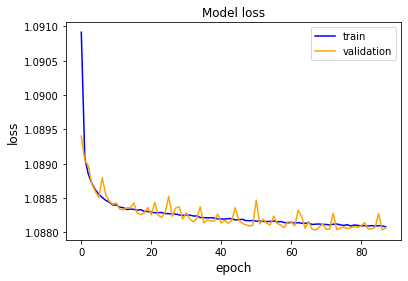

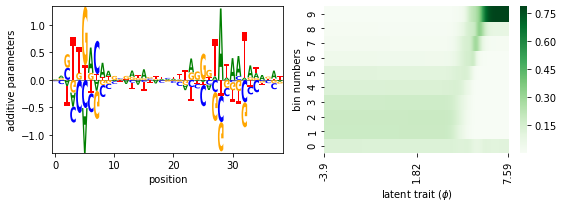

In [7]:
plt.plot(loss_history.history['loss'], color='blue')
plt.plot(loss_history.history['val_loss'], color='orange')
plt.title('Model loss', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['train', 'validation'])
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

# make logo to visualize additive parameters
ax[0].set_ylabel('additive parameters')
ax[0].set_xlabel('position')

theta_df = pd.DataFrame(NAR.return_theta().reshape(39, 4),columns=['A', 'C', 'G', 'T'])

additive_logo = logomaker.Logo(theta_df,ax=ax[0])

if noise_model.T[noise_model.T.shape[0] - 1][0] > noise_model.T[noise_model.T.shape[0] - 1][
            noise_model.T.shape[1] - 1]:
    noise_model_heatmap = sns.heatmap(pd.DataFrame(noise_model.T).loc[::1, ::-1], cmap='Greens', ax=ax[1])
else:
    noise_model_heatmap = sns.heatmap(noise_model.T, cmap='Greens', ax=ax[1])
ax[1].invert_yaxis()
ax[1].set_xticks(([0, int(len(phi_range) / 2), len(phi_range) - 2]), minor=False)
middle_tick = str(phi_range[int(len(phi_range) / 2)])
ax[1].set_xticklabels(([str(phi_range[0])[1:5], middle_tick[1:5], str(phi_range[len(phi_range) - 1])[1:5]]),
                   minor=False)
ax[1].set_ylabel(' bin numbers')
ax[1].set_xlabel('latent trait ($\phi$)')


plt.tight_layout()
plt.show()
